In [2]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Desktop/julia_codes/GaussianExpansionCavityMethod.jl/examples/linear_OrnteinUhlenbeck`


In [3]:
using Revise 
using Random, Graphs, GaussianExpansionCavityMethod, SparseArrays, LinearAlgebra, Statistics, ProgressMeter, QuadGK, JLD2
using PowerLawSamplers: doubling_up_sampler
ProgressMeter.ijulia_behavior(:append)
using PyCall, Conda
import PyPlot as plt
using LaTeXStrings

rcParams = PyDict(plt.matplotlib["rcParams"])
rcParams["font.size"] = 8

nx = pyimport("networkx")
function to_networkx(g::Graphs.AbstractGraph)
    g_nx = nx.Graph()
    for v in vertices(g)
        g_nx.add_node(Int(v))
    end
    for e in edges(g)
        g_nx.add_edge(Int(src(e)), Int(dst(e)))
    end
    return g_nx
end

to_networkx (generic function with 1 method)

# Markov Chain Monte Carlo (MCMC)

## Single realization of disorder, stochasticity and initial conditions

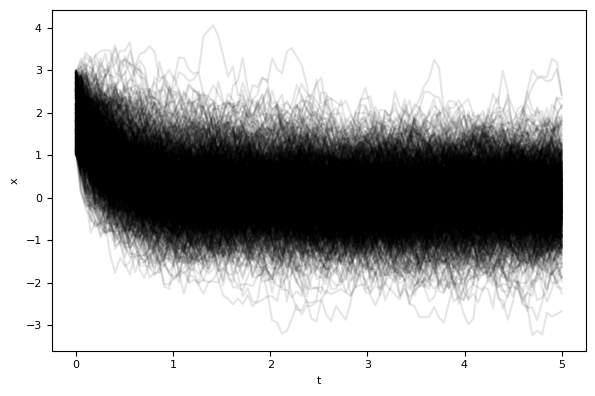

In [35]:
N, K = 1000, 4

rng = Xoshiro(1234)

lam, J, D = 2.5, 1.0/K, 1.0
Jmat = adjacency_matrix(random_regular_graph(N, K; rng=rng), Float64) 
@inbounds @fastmath for i in 1:N
    @inbounds @fastmath @simd for j in i+1:N
        if Jmat[i, j] != 0
            Jmat[i, j] = randn(rng) * sqrt(J)
            Jmat[j, i] = Jmat[i, j]
        end
    end
end
lambdas = fill(lam, N)

model = OUModel(K, Jmat, lambdas, D)

x0_min, x0_max = 1.0, 3.0
x0 = rand(rng, N) * (x0_max - x0_min) .+ x0_min
tmax = 5.0 
tsave=collect(range(0.0, tmax; length=100))

tvec, trajs = sample_OU(model, x0, tmax, tsave; rng=rng)

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)
for i in 1:N
    ax.plot(tvec, view(trajs, i, :), color="k", alpha=0.1)
end
ax.set_xlabel("t")
ax.set_ylabel("x")

display(fig)

## Average over disorder, noise realizations and initial conditions

In [ ]:
N, K = 500, 4

rng = Xoshiro(1234)

lam, J, D = 2.5, 1.0/K, 1.0

x0_min, x0_max = 0.0, 1.0
dt_mc = 1e-3
tmax = 5.0
tsave = collect(range(0.0, tmax; step=dt_mc*100))

nsim = 100

# Define ensemble model
model_ensemble = OUModelRRG(N, K, J, lam, D, x0_min, x0_max)

# Sample ensemble
tvals_alls, traj_alls = sample_ensemble_OU(model_ensemble, tmax, tsave, nsim; rng=rng, showprogress=true, dt=dt_mc);

CompositeException: TaskFailedException

    nested task error: InterruptException:
    Stacktrace:
     [1] Array
       @ ./boot.jl:477 [inlined]
     [2] getindex
       @ ./array.jl:400 [inlined]
     [3] make_seed(n::UInt32)
       @ Random ~/.julia/juliaup/julia-1.9.4+0.aarch64.apple.darwin14/share/julia/stdlib/v1.9/Random/src/RNGs.jl:295
     [4] seed!
       @ ~/.julia/juliaup/julia-1.9.4+0.aarch64.apple.darwin14/share/julia/stdlib/v1.9/Random/src/Xoshiro.jl:156 [inlined]
     [5] macro expansion
       @ ~/Desktop/julia_codes/GaussianExpansionCavityMethod.jl/src/linear_OrnteinUhlenbeck/sample.jl:141 [inlined]
     [6] (::GaussianExpansionCavityMethod.var"#17#threadsfor_fun#44"{GaussianExpansionCavityMethod.var"#17#threadsfor_fun#36#45"{Float64, Float64, Progress, ReentrantLock, Vector{UInt32}, Vector{Vector{Float64}}, Vector{Matrix{Float64}}, Vector{Xoshiro}, Vector{Float64}, Vector{Vector{Float64}}, Vector{OUModelEnsemble}, UnitRange{Int64}}})(tid::Int64; onethread::Bool)
       @ GaussianExpansionCavityMethod ./threadingconstructs.jl:206
     [7] #17#threadsfor_fun
       @ ./threadingconstructs.jl:173 [inlined]
     [8] (::Base.Threads.var"#1#2"{GaussianExpansionCavityMethod.var"#17#threadsfor_fun#44"{GaussianExpansionCavityMethod.var"#17#threadsfor_fun#36#45"{Float64, Float64, Progress, ReentrantLock, Vector{UInt32}, Vector{Vector{Float64}}, Vector{Matrix{Float64}}, Vector{Xoshiro}, Vector{Float64}, Vector{Vector{Float64}}, Vector{OUModelEnsemble}, UnitRange{Int64}}}, Int64})()
       @ Base.Threads ./threadingconstructs.jl:145

In [37]:
teq = 3.0
teq_idx = findfirst(tsave .> teq - dt_mc/2)
tvals_eq = tsave[teq_idx:end]

fig, axs = plt.subplots(2, 2, figsize=(6*2, 4*2), tight_layout=true)

mean_traj, std_traj, autocorr_traj = compute_stats_TTI(traj_alls, teq_idx)
# Only averages
for isim in 1:nsim
    mean, std, autocorr = compute_stats_TTI(traj_alls[isim], teq_idx)
    ax = axs[1,1]
    ax.plot(tvals_eq, mean, color="k", alpha=0.1)
    ax.fill_between(tvals_eq, mean .- std, mean .+ std, color="gray", alpha=0.05)
    ax = axs[2,1]
    ax.plot(tvals_eq, autocorr ./ autocorr[1], color="k", alpha=0.1)
end
ax = axs[1,1]
ax.set_ylabel("x")
ax.plot(tvals_eq, mean_traj, color="red")
ax.fill_between(tvals_eq, mean_traj .- std_traj, mean_traj .+ std_traj, color="red", alpha=0.1)
ax = axs[2,1]
ax.set_xlabel("t")
ax.set_ylabel("Ceq(t)")
ax.plot(tvals_eq, autocorr_traj ./ autocorr_traj[1], color="red")

# Plot all trajectories
ax = axs[1,2]
for isim in 1:nsim
    for i in 1:10
        ax.plot(tvals_alls[isim], view(traj_alls[isim],i,:), color="k", alpha=0.01)
    end
end

plt.display(fig)

InterruptException: InterruptException:

# GECaM approach

## Random Regular Graph with ferromagnetic interactions

In [38]:
N, K = 100, 4

rng = Xoshiro(1234)

lam, J, D = 1.5, 1.0/K, 1.0
Jmat = adjacency_matrix(random_regular_graph(N, K; rng=rng), Float64) .* J
lambdas = fill(lam, N)

x0_min, x0_max = 1.0, 1.0
gen_J(N, K, J_params; rng=Xoshiro(1234)) = deepcopy(Jmat)
gen_x0(N, x0_params; rng=Xoshiro(1234)) = rand(rng, N) .* (x0_params[2] - x0_params[1]) .+ x0_params[1]
J_params = [J]
x0_params = [x0_min, x0_max]

ensemble_model = OUModelEnsemble(N, K, gen_J, J_params, lambdas, D, gen_x0, x0_params)

dt_mc = 1e-2
tmax = 100.0
tsave_mc = collect(range(0.0, tmax; step=dt_mc))
T_mc = length(tsave_mc)

nsim = 100

# Sample ensemble
tvals_alls, traj_alls = sample_ensemble_OU(ensemble_model, tmax, tsave_mc, nsim; rng=rng, showprogress=true, dt=dt_mc);

CompositeException: TaskFailedException

    nested task error: InterruptException:
    Stacktrace:
      [1] _updateProgress!(p::Progress; showvalues::Tuple{}, truncate_lines::Bool, valuecolor::Symbol, offset::Int64, keep::Bool, desc::Nothing, ignore_predictor::Bool, force::Bool, color::Symbol, max_steps::Int64)
        @ ProgressMeter ~/.julia/packages/ProgressMeter/kniaW/src/ProgressMeter.jl:268
      [2] _updateProgress!
        @ ~/.julia/packages/ProgressMeter/kniaW/src/ProgressMeter.jl:217 [inlined]
      [3] #updateProgress!#9
        @ ~/.julia/packages/ProgressMeter/kniaW/src/ProgressMeter.jl:213 [inlined]
      [4] updateProgress!
        @ ~/.julia/packages/ProgressMeter/kniaW/src/ProgressMeter.jl:211 [inlined]
      [5] #18
        @ ~/.julia/packages/ProgressMeter/kniaW/src/ProgressMeter.jl:486 [inlined]
      [6] lock_if_threading
        @ ~/.julia/packages/ProgressMeter/kniaW/src/ProgressMeter.jl:470 [inlined]
      [7] #next!#17
        @ ~/.julia/packages/ProgressMeter/kniaW/src/ProgressMeter.jl:484 [inlined]
      [8] next!
        @ ~/.julia/packages/ProgressMeter/kniaW/src/ProgressMeter.jl:483 [inlined]
      [9] macro expansion
        @ ~/Desktop/julia_codes/GaussianExpansionCavityMethod.jl/src/linear_OrnteinUhlenbeck/sample.jl:157 [inlined]
     [10] (::GaussianExpansionCavityMethod.var"#17#threadsfor_fun#44"{GaussianExpansionCavityMethod.var"#17#threadsfor_fun#36#45"{Float64, Float64, Progress, ReentrantLock, Vector{UInt32}, Vector{Vector{Float64}}, Vector{Matrix{Float64}}, Vector{Xoshiro}, Vector{Float64}, Vector{Vector{Float64}}, Vector{OUModelEnsemble}, UnitRange{Int64}}})(tid::Int64; onethread::Bool)
        @ GaussianExpansionCavityMethod ./threadingconstructs.jl:206
     [11] #17#threadsfor_fun
        @ ./threadingconstructs.jl:173 [inlined]
     [12] (::Base.Threads.var"#1#2"{GaussianExpansionCavityMethod.var"#17#threadsfor_fun#44"{GaussianExpansionCavityMethod.var"#17#threadsfor_fun#36#45"{Float64, Float64, Progress, ReentrantLock, Vector{UInt32}, Vector{Vector{Float64}}, Vector{Matrix{Float64}}, Vector{Xoshiro}, Vector{Float64}, Vector{Vector{Float64}}, Vector{OUModelEnsemble}, UnitRange{Int64}}}, Int64})()
        @ Base.Threads ./threadingconstructs.jl:145

In [39]:
tvec_mc = collect(range(0.0, tmax; length=200))
tidxs_mc = [argmin(abs.(tsave_mc .- t)) for t in tvec_mc]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Plot all trajectories
for isim in rand(rng, 1:nsim, 30)
    for i in rand(rng, 1:N, 50)
        ax.plot(tvec_mc, view(traj_alls[isim],i,tidxs_mc), color="k", alpha=0.01)
    end
end
# Plot mean and std
mean_traj, std_traj = compute_meanstd(traj_alls; time_indices=tidxs_mc)
ax.plot(tvec_mc, mean_traj, color="red")
ax.fill_between(tvec_mc, mean_traj .- std_traj, mean_traj .+ std_traj, color="red", alpha=0.5)
ax.set_ylabel("x")
ax.set_xlabel("t")

plt.display(fig)

InterruptException: InterruptException:

In [40]:
teq = 50.0
teq_idx = argmin(abs.(tsave_mc .- teq))

model = OUModel(K, Jmat, lambdas, D)

dt_G = 1e-1

T_G = Int((tmax-teq)/dt_G)
nodes = run_cavity_EQ(model, dt_G, T_G; showprogress=true)

C, R = compute_averages(nodes, model, T_G);

InterruptException: InterruptException:

In [41]:
fint(t, x, J, l, a) = sqrt(a^2 - x^2) / (1 - x^2) * exp(J * x * t) / (l - J * x)

function analytic_Ceq_RRG(t, K, J, lam, D)
    a = 2 * sqrt(K - 1) / K
    int, err = quadgk(x -> D * K * exp(- lam * t) / (2 * pi) * fint(t, x, J, lam, a), -a, a)
end

InterruptException: InterruptException:

In [42]:
lagvec_mc = vcat(0.0, exp10.(collect(range(log10(1e-10), log10((tmax-teq)); length=100))))
lagidxs_mc = [argmin(abs.(view(tsave_mc,teq_idx:T_mc) .- teq .- t)) for t in lagvec_mc] 
# Remvoe duplicates
lagidxs_mc = unique(lagidxs_mc)
lagvec_mc = tsave_mc[lagidxs_mc]

tvec_G = collect(range(0, T_G*dt_G, length=T_G + 1))

Ceq_analytic = zeros(T_G + 1)
for (idx, t) in enumerate(tvec_G)
    Ceq_analytic[idx], _ = analytic_Ceq_RRG(t, K, J, lam, D)
end

autocorr_traj, err_autocorr_traj, l_idx = compute_autocorr_TTI(traj_alls, teq_idx; lag_indices=lagidxs_mc)
lagvec_mc = tsave_mc[l_idx]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Plot correlations
ax.plot(tvec_G, C, color="blue", label="GECaM")
ax.scatter(lagvec_mc, autocorr_traj, color="black", label="MC")
ax.fill_between(lagvec_mc, autocorr_traj .- err_autocorr_traj, autocorr_traj .+ err_autocorr_traj, color="black", alpha=0.1)
ax.plot(tvec_G, Ceq_analytic ./ Ceq_analytic[1], color="red", label="Analytic")
ax.legend()
ax.set_xlabel("τ")
ax.set_ylabel("Ceq(τ)")
ax.set_title("Equilibrium correlation")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(1e-5, 1.5)
ax.set_xlim(1e-2, 5e1)
ax.grid(alpha=.5)

plt.display(fig)   
fig.savefig("Ceq_RRG_Ferro_N-$(N)_K-$(K)_lam-$(lam)_D-$(D)_J-$(Int(J*K)).png", dpi=300, bbox_inches="tight")

UndefVarError: UndefVarError: `analytic_Ceq_RRG` not defined

In [43]:
isdir("data") || mkdir("data")
isdir("data/RRG_Ferro") || mkdir("data/RRG_Ferro")

jldsave("data/RRG_Ferro/N-$(N)_K-$(K)_lam-$(lam)_D-$(D)_J-$(Int(J*K))_tmax-$(tmax)_nsim-$(nsim)_teq-$(teq).jld2"; tvals_alls, traj_alls, tvec_mc, mean_traj, std_traj, autocorr_traj, err_autocorr_traj, lagvec_mc, lagidxs_mc, tvec_G, C, Ceq_analytic)

InterruptException: InterruptException:

## Erdos-Renyi with ferromagnetic interactions

In [44]:
N, K = 200, 4

rng = Xoshiro(1234)

lam, J, D = 10.0, 1.0/K, 1.0
Jmat = adjacency_matrix(erdos_renyi(N, K/N; rng=rng), Float64) .* J
lambdas = fill(lam, N)

x0_min, x0_max = 1.0, 1.0
gen_J(N, K, J_params; rng=Xoshiro(1234)) = deepcopy(Jmat)
gen_x0(N, x0_params; rng=Xoshiro(1234)) = rand(rng, N) .* (x0_params[2] - x0_params[1]) .+ x0_params[1]
J_params = [J]
x0_params = [x0_min, x0_max]

ensemble_model = OUModelEnsemble(N, K, gen_J, J_params, lambdas, D, gen_x0, x0_params)

dt_mc = 1e-2
tmax = 500.0
tsave_mc = collect(range(0.0, tmax; step=dt_mc))
T_mc = length(tsave_mc)

nsim = 100

# Sample ensemble
tvals_alls, traj_alls = sample_ensemble_OU(ensemble_model, tmax, tsave_mc, nsim; rng=rng, showprogress=true, dt=dt_mc);

InterruptException: InterruptException:

In [45]:
tvec_mc = collect(range(0.0, tmax; length=200))
tidxs_mc = [argmin(abs.(tsave_mc .- t)) for t in tvec_mc]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Plot all trajectories
for isim in rand(rng, 1:nsim, 30)
    for i in rand(rng, 1:N, 50)
        ax.plot(tvec_mc, view(traj_alls[isim],i,tidxs_mc), color="k", alpha=0.01)
    end
end
# Plot mean and std
mean_traj, std_traj = compute_meanstd(traj_alls; time_indices=tidxs_mc)
ax.plot(tvec_mc, mean_traj, color="red")
ax.fill_between(tvec_mc, mean_traj .- std_traj, mean_traj .+ std_traj, color="red", alpha=0.5)
ax.set_ylabel("x")
ax.set_xlabel("t")

plt.display(fig)

InterruptException: InterruptException:

In [ ]:
teq = 495.0
teq_idx = argmin(abs.(tsave_mc .- teq))

model = OUModel(K, Jmat, lambdas, D)

dt_G = 1e-2

T_G = Int((tmax - teq) / dt_G)
nodes = run_cavity_EQ(model, dt_G, T_G; showprogress=true)

C, R = compute_averages(nodes, model, T_G);

In [ ]:
teq = 400.0
teq_idx = argmin(abs.(tsave_mc .- teq))


lagvec_mc = vcat(0.0, exp10.(collect(range(log10(3e-2), log10((tmax-teq)); length=100))))
lagidxs_mc = [argmin(abs.(view(tsave_mc,teq_idx:T_mc) .- teq .- t)) for t in lagvec_mc] 
# Remvoe duplicates
lagidxs_mc = unique(lagidxs_mc)
lagvec_mc = tsave_mc[lagidxs_mc]

tvec_G = collect(range(0, T_G*dt_G, length=T_G + 1))

autocorr_traj, err_autocorr_traj, l_idx = compute_autocorr_TTI(traj_alls, teq_idx; lag_indices=lagidxs_mc)
lagvec_mc = tsave_mc[l_idx]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Plot correlations
ax.plot(tvec_G, C, color="blue", label="GECaM")
ax.scatter(lagvec_mc, autocorr_traj, color="black", label="MC")
ax.fill_between(lagvec_mc, autocorr_traj .- err_autocorr_traj, autocorr_traj .+ err_autocorr_traj, color="black", alpha=0.1)
ax.legend()
ax.set_xlabel("τ")
ax.set_ylabel("Ceq(τ)")
ax.set_title("Equilibrium correlation")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(1e-3, 1.5)
ax.set_xlim(1e-2, 3e0)
ax.grid(alpha=.5)

plt.display(fig)   
fig.savefig("Ceq_ER_Ferro_N-$(N)_K-$(K)_lam-$(lam)_D-$(D)_J-$(Int(J*K)).png", dpi=300, bbox_inches="tight")

In [ ]:
isdir("data") || mkdir("data")
isdir("data/ER_Ferro") || mkdir("data/ER_Ferro")

jldsave("data/ER_Ferro/N-$(N)_K-$(K)_lam-$(lam)_D-$(D)_J-$(Int(J*K))_tmax-$(tmax)_nsim-$(nsim)_teq-$(teq).jld2"; tvals_alls, traj_alls, tvec_mc, mean_traj, std_traj, autocorr_traj, err_autocorr_traj, lagvec_mc, lagidxs_mc, tvec_G, C)

## Random Configuration Model (RCM) with ferromagnetic interactions

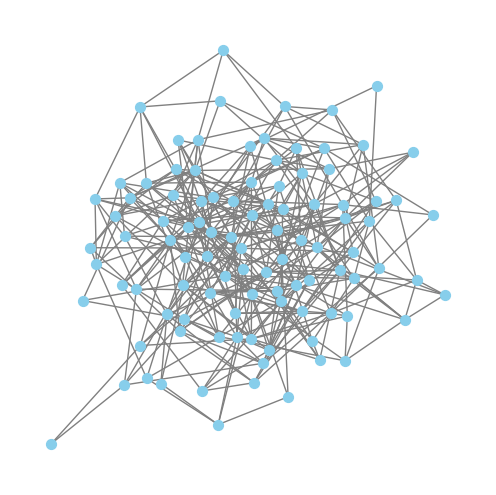

In [4]:
N, Ktarget = 100, 7
alpha = 2.5

rng = Xoshiro(1234)
G = static_scale_free(N, Int(Ktarget*N/2), alpha; rng=rng, finite_size_correction=true)
degs = degree(G)
K = mean(degs)
G_nx = to_networkx(G)

# Draw the graph using networkx and matplotlib
fig, ax = plt.subplots(1, 1, figsize=(5, 5), tight_layout=true)

layout = nx.spring_layout(G_nx, seed=42)
nx.draw(G_nx, pos=layout, ax=ax, with_labels=false, node_color="skyblue", edge_color="gray", node_size=50)
plt.display(fig)

In [5]:
lam, J, D = 3.0, 1.0/K, 1.0
Jmat = adjacency_matrix(G) .* J
lambdas = fill(lam, N)

x0_min, x0_max = 1.0, 1.0
gen_J(N, K, J_params; rng=Xoshiro(1234)) = deepcopy(Jmat)
gen_x0(N, x0_params; rng=Xoshiro(1234)) = rand(rng, N) .* (x0_params[2] - x0_params[1]) .+ x0_params[1]
J_params = [J]
x0_params = [x0_min, x0_max]

ensemble_model = OUModelEnsemble(N, K, gen_J, J_params, lambdas, D, gen_x0, x0_params)

dt_mc = 1e-3
tmax = 200.0
tsave_mc = collect(range(150, tmax; step=1e-2))
T_mc = length(tsave_mc)

nsim = 20

# Sample ensemble
tvals_alls, traj_alls = sample_ensemble_OU(ensemble_model, tmax, tsave_mc, nsim; rng=rng, showprogress=true, dt=dt_mc);

Progress: 100%|███████████████████████████| Time: 0:00:05 ( 0.25  s/it)


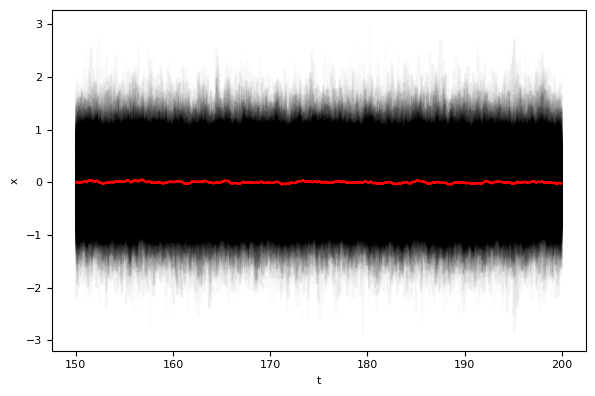

In [6]:
tvec_mc = collect(range(150, tmax; step=1e-2))
tidxs_mc = [argmin(abs.(tsave_mc .- t)) for t in tvec_mc]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Plot all trajectories
for isim in rand(rng, 1:nsim, 30)
    for i in rand(rng, 1:N, 50)
        ax.plot(tvec_mc, view(traj_alls[isim],i,tidxs_mc), color="k", alpha=0.01)
    end
end
# Plot mean and std
mean_traj, std_traj = compute_meanstd(traj_alls; time_indices=tidxs_mc)
ax.plot(tvec_mc, mean_traj, color="red")
ax.fill_between(tvec_mc, mean_traj .- std_traj, mean_traj .+ std_traj, color="red", alpha=0.5)
ax.set_ylabel("x")
ax.set_xlabel("t")

plt.display(fig)

In [7]:
teq = 170.0
teq_idx = argmin(abs.(tsave_mc .- teq))

model = OUModel(K, Jmat, lambdas, D)

dt_G = 1e-2

T_G = Int((tmax - teq) / dt_G)
nodes = run_cavity_EQ(model, dt_G, T_G; showprogress=true)

C, R = compute_averages(nodes, model, T_G);

Cavity update: 100%|██████████████████████| Time: 0:00:29 ( 9.52 ns/it)
Marginal update: 100%|████████████████████| Time: 0:00:03 ( 7.89 ns/it)


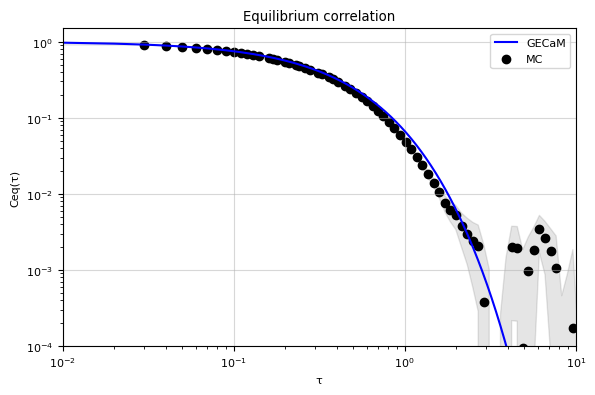

In [16]:
teq = 150.0
teq_idx = argmin(abs.(tsave_mc .- teq))

lagvec_mc = vcat(0.0, exp10.(collect(range(log10(3e-2), log10((tmax-teq)); length=100))))
lagidxs_mc = [argmin(abs.(tsave_mc .- teq .- t)) for t in lagvec_mc] 
# Remvoe duplicates
lagidxs_mc = unique(lagidxs_mc)

tvec_G = collect(range(0, T_G*dt_G, length=T_G+1))

autocorr_traj, err_autocorr_traj, l_idx = compute_autocorr_TTI(traj_alls, 1; lag_indices=lagidxs_mc)
lagvec_mc = tsave_mc[l_idx] .- teq

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Plot correlations
ax.plot(tvec_G, C, color="blue", label="GECaM")
ax.scatter(lagvec_mc, autocorr_traj, color="black", label="MC")
ax.fill_between(lagvec_mc, autocorr_traj .- err_autocorr_traj, autocorr_traj .+ err_autocorr_traj, color="black", alpha=0.1)
ax.legend()
ax.set_xlabel("τ")
ax.set_ylabel("Ceq(τ)")
ax.set_title("Equilibrium correlation")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(1e-4, 1.5)
ax.set_xlim(1e-2, 1e1)
ax.grid(alpha=.5)

plt.display(fig)   
fig.savefig("Ceq_RCM_Ferro_N-$(N)_K-$(K)_alpha-$(alpha)_lam-$(lam)_D-$(D)_J-$(round(J*K)).png", dpi=300, bbox_inches="tight")

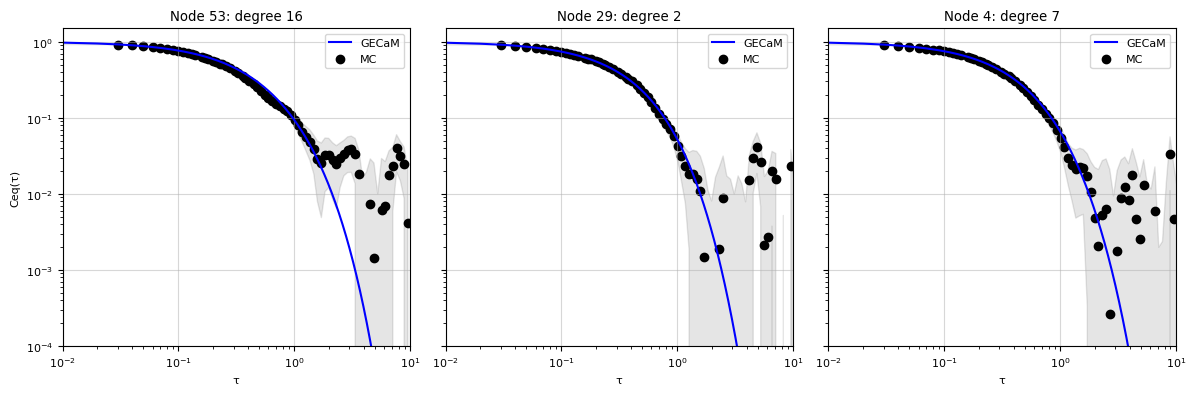

In [21]:
degmax = maximum(degs)
degmin = max(minimum(degs), 1)

idxmax = findfirst(x -> x == degmax, degs)
idxmin = findfirst(x -> x == degmin, degs)
idxavg = findfirst(x -> abs(x - K) < 1e-3, degs)

traj_max = zeros(nsim, T_mc)
traj_min = zeros(nsim, T_mc)
traj_avg = zeros(nsim, T_mc)
@inbounds for (isim, traj) in enumerate(traj_alls)
    traj_max[isim, :] .= traj[idxmax, :]
    traj_min[isim, :] .= traj[idxmin, :]
    traj_avg[isim, :] .= traj[idxavg, :]
end
autocorr_max, err_autocorr_max, l_idx_max = compute_autocorr_TTI(traj_max, teq_idx; lag_indices=lagidxs_mc)
lagvec_mc_max = tsave_mc[l_idx_max] .- teq
autocorr_min, err_autocorr_min, l_idx_min = compute_autocorr_TTI(traj_min, teq_idx; lag_indices=lagidxs_mc)
lagvec_mc_min = tsave_mc[l_idx_min] .- teq
autocorr_avg, err_autocorr_avg, l_idx_avg = compute_autocorr_TTI(traj_avg, teq_idx; lag_indices=lagidxs_mc)
lagvec_mc_avg = tsave_mc[l_idx_avg] .- teq

fig, axs = plt.subplots(1, 3, figsize=(6*2, 4), tight_layout=true, sharey=true)

# Plot correlations
ax = axs[1]
ax.plot(tvec_G, nodes[idxmax].marg.C, color="blue", label="GECaM")
ax.scatter(lagvec_mc_max, autocorr_max, color="black", label="MC")
ax.fill_between(lagvec_mc_max, autocorr_max .- err_autocorr_max, autocorr_max .+ err_autocorr_max, color="black", alpha=0.1)
ax.legend()
ax.set_xlabel("τ")
ax.set_ylabel("Ceq(τ)")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(1e-4, 1.5)
ax.set_xlim(1e-2, 1e1)
ax.grid(alpha=.5)
ax.set_title("Node $idxmax: degree $(degs[idxmax])")

ax = axs[2]
ax.plot(tvec_G, nodes[idxmin].marg.C, color="blue", label="GECaM")
ax.scatter(lagvec_mc_min, autocorr_min, color="black", label="MC")
ax.fill_between(lagvec_mc_min, autocorr_min .- err_autocorr_min, autocorr_min .+ err_autocorr_min, color="black", alpha=0.1)
ax.legend()
ax.set_xlabel("τ")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(1e-2, 1e1)
ax.grid(alpha=.5)
ax.set_title("Node $idxmin: degree $(degs[idxmin])")  

ax = axs[3]
ax.plot(tvec_G, nodes[idxavg].marg.C, color="blue", label="GECaM")
ax.scatter(lagvec_mc_avg, autocorr_avg, color="black", label="MC")
ax.fill_between(lagvec_mc_avg, autocorr_avg .- err_autocorr_avg, autocorr_avg .+ err_autocorr_avg, color="black", alpha=0.1)
ax.legend()
ax.set_xlabel("τ")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(1e-2, 1e1)
ax.grid(alpha=.5)
ax.set_title("Node $idxavg: degree $(degs[idxavg])")

plt.display(fig)

fig.savefig("Ceq_degs_RCM_Ferro_N-$(N)_K-$(K)_alpha-$(alpha)_lam-$(lam)_D-$(D)_J-$(round(J*K)).png", dpi=300, bbox_inches="tight")

In [44]:
isdir("data") || mkdir("data")
isdir("data/RCM_Ferro") || mkdir("data/RCM_Ferro")

jldsave("data/RCM_Ferro/N-$(N)_K-$(K)_lam-$(lam)_D-$(D)_J-$(Int(J*K))_tmax-$(tmax)_nsim-$(nsim)_teq-$(teq).jld2"; tvals_alls, traj_alls, tvec_mc, mean_traj, std_traj, autocorr_traj, err_autocorr_traj, lagvec_mc, lagidxs_mc, tvec_G, C)

## Barabasi Albert (BA) with ferromagnetic interactions

Progress: 100%|███████████████████████████| Time: 0:00:22 ( 0.22  s/it)


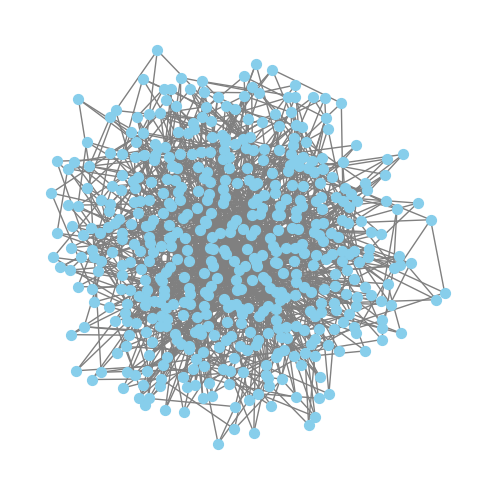

In [20]:
N, Ktarget = 500, 3

rng = Xoshiro(1234)
G = barabasi_albert(N, Ktarget; rng=rng)
degs = degree(G)
K = mean(degs)
G_nx = to_networkx(G)

# Draw the graph using networkx and matplotlib
fig, ax = plt.subplots(1, 1, figsize=(5, 5), tight_layout=true)

layout = nx.spring_layout(G_nx, seed=42)
nx.draw(G_nx, pos=layout, ax=ax, with_labels=false, node_color="skyblue", edge_color="gray", node_size=50)
#plt.display(fig)

lam, J, D = 3.0, 1.0/K, 1.0
Jmat = adjacency_matrix(G) .* J
lambdas = fill(lam, N)

x0_min, x0_max = 1.0, 1.0
gen_J(N, K, J_params; rng=Xoshiro(1234)) = deepcopy(Jmat)
gen_x0(N, x0_params; rng=Xoshiro(1234)) = rand(rng, N) .* (x0_params[2] - x0_params[1]) .+ x0_params[1]
J_params = [J]
x0_params = [x0_min, x0_max]

ensemble_model = OUModelEnsemble(N, K, gen_J, J_params, lambdas, D, gen_x0, x0_params)

dt_mc = 1e-2
tmax = 500.0
tsave_mc = collect(range(0.0, tmax; step=dt_mc))
T_mc = length(tsave_mc)

nsim = 100

# Sample ensemble
tvals_alls, traj_alls = sample_ensemble_OU(ensemble_model, tmax, tsave_mc, nsim; rng=rng, showprogress=true, dt=dt_mc);

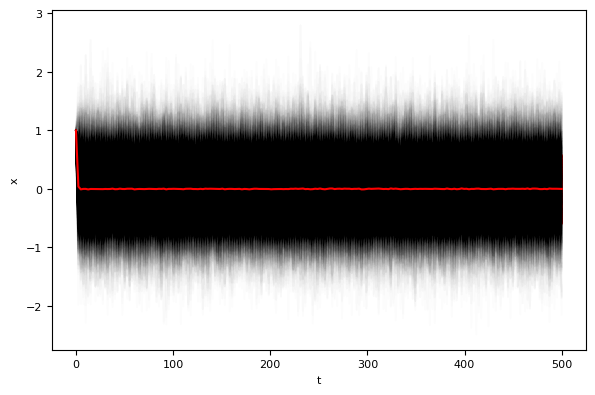

PyObject Text(0.5, 20.0, 't')

In [21]:
tvec_mc = collect(range(0.0, tmax; length=200))
tidxs_mc = [argmin(abs.(tsave_mc .- t)) for t in tvec_mc]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Plot all trajectories
for isim in rand(rng, 1:nsim, 30)
    for i in rand(rng, 1:N, 50)
        ax.plot(tvec_mc, view(traj_alls[isim],i,tidxs_mc), color="k", alpha=0.01)
    end
end
# Plot mean and std
mean_traj, std_traj = compute_meanstd(traj_alls; time_indices=tidxs_mc)
ax.plot(tvec_mc, mean_traj, color="red")
ax.fill_between(tvec_mc, mean_traj .- std_traj, mean_traj .+ std_traj, color="red", alpha=0.5)
ax.set_ylabel("x")
ax.set_xlabel("t")

#plt.display(fig)

In [22]:
teq = 470.0
teq_idx = argmin(abs.(tsave_mc .- teq))

model = OUModel(K, Jmat, lambdas, D)

dt_G = 1e-2

T_G = Int((tmax - teq) / dt_G)
nodes = run_cavity_EQ(model, dt_G, T_G; showprogress=true)

C, R = compute_averages(nodes, model, T_G);

Cavity update: 100%|██████████████████████| Time: 0:01:13 ( 5.45 ns/it)
Marginal update: 100%|████████████████████| Time: 0:00:10 ( 4.64 ns/it)


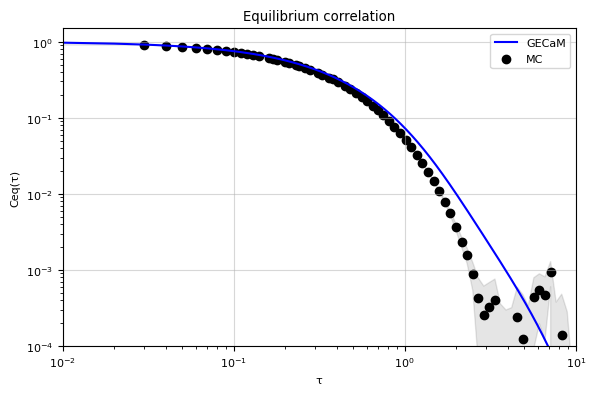

In [23]:
teq = 450.0
teq_idx = argmin(abs.(tsave_mc .- teq))


lagvec_mc = vcat(0.0, exp10.(collect(range(log10(3e-2), log10((tmax-teq)); length=100))))
lagidxs_mc = [argmin(abs.(view(tsave_mc,teq_idx:T_mc) .- teq .- t)) for t in lagvec_mc] 
# Remvoe duplicates
lagidxs_mc = unique(lagidxs_mc)
lagvec_mc = tsave_mc[lagidxs_mc]

tvec_G = collect(range(0, T_G*dt_G, length=T_G+1))

autocorr_traj, err_autocorr_traj, l_idx = compute_autocorr_TTI(traj_alls, teq_idx; lag_indices=lagidxs_mc)
lagvec_mc = tsave_mc[l_idx]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Plot correlations
ax.plot(tvec_G, C, color="blue", label="GECaM")
ax.scatter(lagvec_mc, autocorr_traj, color="black", label="MC")
ax.fill_between(lagvec_mc, autocorr_traj .- err_autocorr_traj, autocorr_traj .+ err_autocorr_traj, color="black", alpha=0.1)
ax.legend()
ax.set_xlabel("τ")
ax.set_ylabel("Ceq(τ)")
ax.set_title("Equilibrium correlation")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(1e-4, 1.5)
ax.set_xlim(1e-2, 1e1)
ax.grid(alpha=.5)

#plt.display(fig)   
fig.savefig("Ceq_RCM_Ferro_N-$(N)_K-$(K)_alpha-$(alpha)_lam-$(lam)_D-$(D)_J-$(round(J*K)).png", dpi=300, bbox_inches="tight")

In [7]:
isdir("data") || mkdir("data")
isdir("data/RCM_Ferro") || mkdir("data/RCM_Ferro")

jldsave("data/RCM_Ferro/N-$(N)_K-$(K)_lam-$(lam)_D-$(D)_J-$(Int(J*K))_tmax-$(tmax)_nsim-$(nsim)_teq-$(teq).jld2"; tvals_alls, traj_alls, tvec_mc, mean_traj, std_traj, autocorr_traj, err_autocorr_traj, lagvec_mc, lagidxs_mc, tvec_G, C)

## Random Regular Graph with disordered interactions (bimodal)

In [ ]:
N, K = 200, 3

rng = Xoshiro(1234)

lam, J, D = 1.2, 1.0/K, 1.0
Jmat = adjacency_matrix(random_regular_graph(N, K; rng=rng), Float64)
@inbounds @fastmath for i in 1:N
    @inbounds @fastmath @simd for j in i+1:N
        if Jmat[i, j] != 0
            Jmat[i, j] = rand(rng) > 0.5 ? J : -J
            Jmat[j, i] = Jmat[i, j]
        end
    end
end
lambdas = fill(lam, N)

x0_min, x0_max = 1.0, 1.0
gen_J(N, K, J_params; rng=Xoshiro(1234)) = deepcopy(Jmat)
gen_x0(N, x0_params; rng=Xoshiro(1234)) = rand(rng, N) .* (x0_params[2] - x0_params[1]) .+ x0_params[1]
J_params = [J]
x0_params = [x0_min, x0_max]

ensemble_model = OUModelEnsemble(N, K, gen_J, J_params, lambdas, D, gen_x0, x0_params)

dt_mc = 1e-2
tmax = 300.0
tsave_mc = collect(range(0.0, tmax; step=dt_mc))
T_mc = length(tsave_mc)

nsim = 500

# Sample ensemble
tvals_alls, traj_alls = sample_ensemble_OU(ensemble_model, tmax, tsave_mc, nsim; rng=rng, showprogress=true, dt=dt_mc);

In [ ]:
tvec_mc = collect(range(0.0, tmax; length=200))
tidxs_mc = [argmin(abs.(tsave_mc .- t)) for t in tvec_mc]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Plot all trajectories
for isim in rand(rng, 1:nsim, 30)
    for i in rand(rng, 1:N, 50)
        ax.plot(tvec_mc, view(traj_alls[isim],i,tidxs_mc), color="k", alpha=0.01)
    end
end
# Plot mean and std
mean_traj, std_traj = compute_meanstd(traj_alls; time_indices=tidxs_mc)
ax.plot(tvec_mc, mean_traj, color="red")
ax.fill_between(tvec_mc, mean_traj .- std_traj, mean_traj .+ std_traj, color="red", alpha=0.5)
ax.set_ylabel("x")
ax.set_xlabel("t")

plt.display(fig)

In [ ]:
teq = 200.0
teq_idx = argmin(abs.(tsave_mc .- teq))

model = OUModel(K, Jmat, lambdas, D)

dt_G = 1e-2

T_G = Int((tmax-teq)/dt_G)
nodes = run_cavity_EQ(model, dt_G, T_G; showprogress=true)

C, R = compute_averages(nodes, model, T_G);

In [ ]:
lagvec_mc = exp10.(collect(range(log10(1e-2), log10((tmax-teq)); length=100)))
lagidxs_mc = [argmin(abs.(view(tsave_mc,teq_idx:T_mc) .- teq .- t)) for t in lagvec_mc] 
# Remvoe duplicates
lagidxs_mc = unique(lagidxs_mc)
lagvec_mc = tsave_mc[lagidxs_mc]

tvec_G = collect(range(0, T_G*dt_G, length=T_G + 1))

autocorr_traj, err_autocorr_traj, l_idx = compute_autocorr_TTI(traj_alls, teq_idx; lag_indices=lagidxs_mc)
lagvec_mc = tsave_mc[l_idx]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Plot correlations
ax.plot(tvec_G, C, color="blue", label="GECaM")
ax.scatter(lagvec_mc, autocorr_traj, color="black", label="MC")
ax.fill_between(lagvec_mc, autocorr_traj .- err_autocorr_traj, autocorr_traj .+ err_autocorr_traj, color="black", alpha=0.1)
ax.legend()
ax.set_xlabel("τ")
ax.set_ylabel("Ceq(τ)")
ax.set_title("Equilibrium correlation")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(1e-4, 1.5)
ax.set_xlim(1e-2, 5e1)
ax.grid(alpha=.5)

plt.display(fig)   
fig.savefig("Ceq_RRG_Dis_Bim_N-$(N)_K-$(K)_lam-$(lam)_D-$(D)_J-$(Int(J*K)).png", dpi=300, bbox_inches="tight")

In [ ]:
isdir("data") || mkdir("data")
isdir("data/RRG_Dis") || mkdir("data/RRG_Dis")

jldsave("data/RRG_Dis/N-$(N)_K-$(K)_lam-$(lam)_D-$(D)_J-$(Int(J*K))_tmax-$(tmax)_nsim-$(nsim)_teq-$(teq).jld2"; tvals_alls, traj_alls, tvec_mc, mean_traj, std_traj, autocorr_traj, err_autocorr_traj, lagvec_mc, lagidxs_mc, tvec_G, C)

## Erdos-Renyi with disordered interactions (bimodal)

In [ ]:
N, K = 100, 4

rng = Xoshiro(1234)

lam, J, D = 1.3, 1.0/K, 1.0
Jmat = adjacency_matrix(erdos_renyi(N, K/N; rng=rng), Float64) 
@inbounds @fastmath for i in 1:N
    @inbounds @fastmath @simd for j in i+1:N
        if Jmat[i, j] != 0
            Jmat[i, j] = rand(rng) > 0.5 ? J : -J
            Jmat[j, i] = Jmat[i, j]
        end
    end
end
lambdas = fill(lam, N)

x0_min, x0_max = 1.0, 1.0
gen_J(N, K, J_params; rng=Xoshiro(1234)) = deepcopy(Jmat)
gen_x0(N, x0_params; rng=Xoshiro(1234)) = rand(rng, N) .* (x0_params[2] - x0_params[1]) .+ x0_params[1]
J_params = [J]
x0_params = [x0_min, x0_max]

ensemble_model = OUModelEnsemble(N, K, gen_J, J_params, lambdas, D, gen_x0, x0_params)

dt_mc = 1e-2
tmax = 300.0
tsave_mc = collect(range(0.0, tmax; step=dt_mc))
T_mc = length(tsave_mc)

nsim = 500

# Sample ensemble
tvals_alls, traj_alls = sample_ensemble_OU(ensemble_model, tmax, tsave_mc, nsim; rng=rng, showprogress=true, dt=dt_mc);

In [ ]:
tvec_mc = collect(range(0.0, tmax; length=200))
tidxs_mc = [argmin(abs.(tsave_mc .- t)) for t in tvec_mc]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Plot all trajectories
for isim in rand(rng, 1:nsim, 30)
    for i in rand(rng, 1:N, 50)
        ax.plot(tvec_mc, view(traj_alls[isim],i,tidxs_mc), color="k", alpha=0.01)
    end
end
# Plot mean and std
mean_traj, std_traj = compute_meanstd(traj_alls; time_indices=tidxs_mc)
ax.plot(tvec_mc, mean_traj, color="red")
ax.fill_between(tvec_mc, mean_traj .- std_traj, mean_traj .+ std_traj, color="red", alpha=0.5)
ax.set_ylabel("x")
ax.set_xlabel("t")

plt.display(fig)

In [ ]:
teq = 200.0
teq_idx = argmin(abs.(tsave_mc .- teq))

model = OUModel(K, Jmat, lambdas, D)

dt_G = 1e-2

T_G = Int((tmax-teq)/dt_G)
nodes = run_cavity_EQ(model, dt_G, T_G; showprogress=true)

C, R = compute_averages(nodes, model, T_G);

In [ ]:
lagvec_mc = exp10.(collect(range(log10(1e-2), log10((tmax-teq)); length=100)))
lagidxs_mc = [argmin(abs.(view(tsave_mc,teq_idx:T_mc) .- teq .- t)) for t in lagvec_mc] 
# Remvoe duplicates
lagidxs_mc = unique(lagidxs_mc)
lagvec_mc = tsave_mc[lagidxs_mc]

tvec_G = collect(range(0, T_G*dt_G, length=T_G + 1))

autocorr_traj, err_autocorr_traj, l_idx = compute_autocorr_TTI(traj_alls, teq_idx; lag_indices=lagidxs_mc)
lagvec_mc = tsave_mc[l_idx]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Plot correlations
ax.plot(tvec_G, C, color="blue", label="GECaM")
ax.scatter(lagvec_mc, autocorr_traj, color="black", label="MC")
ax.fill_between(lagvec_mc, autocorr_traj .- err_autocorr_traj, autocorr_traj .+ err_autocorr_traj, color="black", alpha=0.1)
ax.legend()
ax.set_xlabel("τ")
ax.set_ylabel("Ceq(τ)")
ax.set_title("Equilibrium correlation")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(1e-3, 1.5)
ax.set_xlim(1e-2, 5e1)
ax.grid(alpha=.5)

plt.display(fig)   
fig.savefig("Ceq_ER_Dis_Bim_N-$(N)_K-$(K)_lam-$(lam)_D-$(D)_J-$(Int(J*K)).png", dpi=300, bbox_inches="tight")

In [ ]:
isdir("data") || mkdir("data")
isdir("data/ER_Dis") || mkdir("data/ER_Dis")

jldsave("data/ER_Dis/N-$(N)_K-$(K)_lam-$(lam)_D-$(D)_J-$(Int(J*K))_tmax-$(tmax)_nsim-$(nsim)_teq-$(teq).jld2"; tvals_alls, traj_alls, tvec_mc, mean_traj, std_traj, autocorr_traj, err_autocorr_traj, lagvec_mc, lagidxs_mc, tvec_G, C)

## Random Configuration Model (RCM) with disordered interactions (bimodal)

In [40]:
N = 1000
alpha = 2.7
kmin = 1

rng = Xoshiro(1234)

degs = doubling_up_sampler.(alpha, kmin, rand(rng, N))
sum_deg = sum(degs)
while !(iseven(sum_deg))
    degs = doubling_up_sampler.(alpha, kmin, rand(rng, N))
    sum_deg = sum(degs)
end
K = mean(degs)
G = random_configuration_model(N, degs)
G_nx = to_networkx(G)

# Draw the graph using networkx and matplotlib
fig, ax = plt.subplots(1, 1, figsize=(5, 5), tight_layout=true)

layout = nx.spring_layout(G_nx, seed=42)
nx.draw(G_nx, pos=layout, ax=ax, with_labels=false, node_color="skyblue", edge_color="gray", node_size=50)
plt.display(fig)

lam, J, D = 2.5, 1.0/K, 1.0
Jmat = adjacency_matrix(G, Float64)
@inbounds @fastmath for i in 1:N
    @inbounds @fastmath @simd for j in i+1:N
        if Jmat[i, j] != 0
            Jmat[i, j] = rand(rng) > 0.5 ? J : -J
            Jmat[j, i] = Jmat[i, j]
        end
    end
end
lambdas = fill(lam, N)

x0_min, x0_max = 1.0, 1.0
gen_J(N, K, J_params; rng=Xoshiro(1234)) = deepcopy(Jmat)
gen_x0(N, x0_params; rng=Xoshiro(1234)) = rand(rng, N) .* (x0_params[2] - x0_params[1]) .+ x0_params[1]
J_params = [J]
x0_params = [x0_min, x0_max]

ensemble_model = OUModelEnsemble(N, K, gen_J, J_params, lambdas, D, gen_x0, x0_params)

dt_mc = 1e-2
tmax = 500.0
tsave_mc = collect(range(0.0, tmax; step=dt_mc))
T_mc = length(tsave_mc)

nsim = 100

# Sample ensemble
tvals_alls, traj_alls = sample_ensemble_OU(ensemble_model, tmax, tsave_mc, nsim; rng=rng, showprogress=true, dt=dt_mc);

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /Users/mattiatarabolo/.julia/packages/PyCall/1gn3u/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ModuleNotFoundError'>
ModuleNotFoundError("No module named 'scipy'")
  File "<class 'networkx.utils.decorators.argmap'> compilation 4", line 4, in argmap_spring_layout_1
    import inspect
            ^^^^^^^
  File "/Users/mattiatarabolo/.julia/conda/3/aarch64/lib/python3.12/site-packages/networkx/drawing/layout.py", line 481, in spring_layout
    A = nx.to_scipy_sparse_array(G, weight=weight, dtype="f")
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mattiatarabolo/.julia/conda/3/aarch64/lib/python3.12/site-packages/networkx/utils/decorators.py", line 788, in func
    return argmap._lazy_compile(__wrapper)(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<class 'networkx.utils.decorators.argmap'> compilation 16", line 3, in argmap_to_scipy_sparse_array_13
    import gzip
            ^^^^
  File "/Users/mattiatarabolo/.julia/conda/3/aarch64/lib/python3.12/site-packages/networkx/utils/backends.py", line 967, in __call__
    return self.orig_func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mattiatarabolo/.julia/conda/3/aarch64/lib/python3.12/site-packages/networkx/convert_matrix.py", line 665, in to_scipy_sparse_array
    import scipy as sp


In [41]:
tvec_mc = collect(range(0.0, tmax; length=200))
tidxs_mc = [argmin(abs.(tsave_mc .- t)) for t in tvec_mc]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Plot all trajectories
for isim in rand(rng, 1:nsim, 30)
    for i in rand(rng, 1:N, 50)
        ax.plot(tvec_mc, view(traj_alls[isim],i,tidxs_mc), color="k", alpha=0.01)
    end
end
# Plot mean and std
mean_traj, std_traj = compute_meanstd(traj_alls; time_indices=tidxs_mc)
ax.plot(tvec_mc, mean_traj, color="red")
ax.fill_between(tvec_mc, mean_traj .- std_traj, mean_traj .+ std_traj, color="red", alpha=0.5)
ax.set_ylabel("x")
ax.set_xlabel("t")

plt.display(fig)

BoundsError: BoundsError: attempt to access 200×50001 Matrix{Float64} at index [499, [1, 252, 504, 755, 1006, 1257, 1509, 1760, 2011, 2262, 2514, 2765, 3016, 3267, 3519, 3770, 4021, 4272, 4524, 4775, 5026, 5277, 5529, 5780, 6031, 6282, 6534, 6785, 7036, 7287, 7539, 7790, 8041, 8292, 8544, 8795, 9046, 9297, 9549, 9800, 10051, 10303, 10554, 10805, 11056, 11308, 11559, 11810, 12061, 12313, 12564, 12815, 13066, 13318, 13569, 13820, 14071, 14323, 14574, 14825, 15076, 15328, 15579, 15830, 16081, 16333, 16584, 16835, 17086, 17338, 17589, 17840, 18091, 18343, 18594, 18845, 19096, 19348, 19599, 19850, 20102, 20353, 20604, 20855, 21107, 21358, 21609, 21860, 22112, 22363, 22614, 22865, 23117, 23368, 23619, 23870, 24122, 24373, 24624, 24875, 25127, 25378, 25629, 25880, 26132, 26383, 26634, 26885, 27137, 27388, 27639, 27890, 28142, 28393, 28644, 28895, 29147, 29398, 29649, 29900, 30152, 30403, 30654, 30906, 31157, 31408, 31659, 31911, 32162, 32413, 32664, 32916, 33167, 33418, 33669, 33921, 34172, 34423, 34674, 34926, 35177, 35428, 35679, 35931, 36182, 36433, 36684, 36936, 37187, 37438, 37689, 37941, 38192, 38443, 38694, 38946, 39197, 39448, 39699, 39951, 40202, 40453, 40705, 40956, 41207, 41458, 41710, 41961, 42212, 42463, 42715, 42966, 43217, 43468, 43720, 43971, 44222, 44473, 44725, 44976, 45227, 45478, 45730, 45981, 46232, 46483, 46735, 46986, 47237, 47488, 47740, 47991, 48242, 48493, 48745, 48996, 49247, 49498, 49750, 50001]]

In [38]:
teq = 470.0
teq_idx = argmin(abs.(tsave_mc .- teq))

model = OUModel(K, Jmat, lambdas, D)

dt_G = 1e-2

T_G = Int((tmax - teq) / dt_G)
nodes = run_cavity_EQ(model, dt_G, T_G; showprogress=true)

C, R = compute_averages(nodes, model, T_G);

Cavity update: 100%|██████████████████████| Time: 0:00:14 ( 5.49 ns/it)
Marginal update: 100%|████████████████████| Time: 0:00:04 ( 4.55 ns/it)


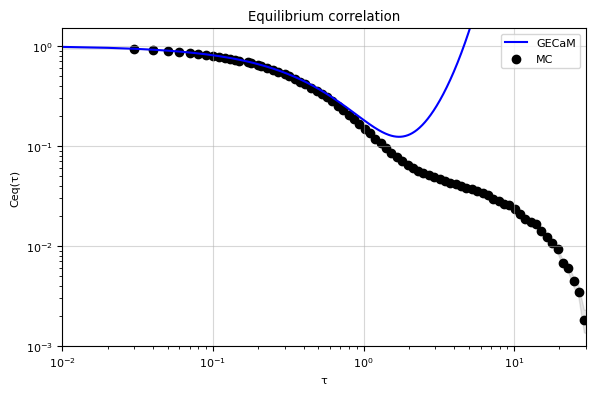

In [39]:
teq = 400.0
teq_idx = argmin(abs.(tsave_mc .- teq))


lagvec_mc = vcat(0.0, exp10.(collect(range(log10(3e-2), log10((tmax-teq)); length=100))))
lagidxs_mc = [argmin(abs.(view(tsave_mc,teq_idx:T_mc) .- teq .- t)) for t in lagvec_mc] 
# Remvoe duplicates
lagidxs_mc = unique(lagidxs_mc)
lagvec_mc = tsave_mc[lagidxs_mc]

tvec_G = collect(range(0, T_G*dt_G, length=T_G + 1))

autocorr_traj, err_autocorr_traj, l_idx = compute_autocorr_TTI(traj_alls, teq_idx; lag_indices=lagidxs_mc)
lagvec_mc = tsave_mc[l_idx]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Plot correlations
ax.plot(tvec_G, C, color="blue", label="GECaM")
ax.scatter(lagvec_mc, autocorr_traj, color="black", label="MC")
ax.fill_between(lagvec_mc, autocorr_traj .- err_autocorr_traj, autocorr_traj .+ err_autocorr_traj, color="black", alpha=0.1)
ax.legend()
ax.set_xlabel("τ")
ax.set_ylabel("Ceq(τ)")
ax.set_title("Equilibrium correlation")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(1e-3, 1.5)
ax.set_xlim(1e-2, 3e1)
ax.grid(alpha=.5)

plt.display(fig)   
fig.savefig("Ceq_RCM_Dis_Bim_N-$(N)_K-$(K)_lam-$(lam)_D-$(D)_J-$(round(J*K)).png", dpi=300, bbox_inches="tight")

In [26]:
isdir("data") || mkdir("data")
isdir("data/RCM_Dis_Bim") || mkdir("data/RCM_Dis_Bim")

jldsave("data/RCM_Dis_Bim/N-$(N)_K-$(K)_lam-$(lam)_D-$(D)_J-$(Int(J*K))_tmax-$(tmax)_nsim-$(nsim)_teq-$(teq).jld2"; tvals_alls, traj_alls, tvec_mc, mean_traj, std_traj, autocorr_traj, err_autocorr_traj, lagvec_mc, lagidxs_mc, tvec_G, C)

## Plot all together

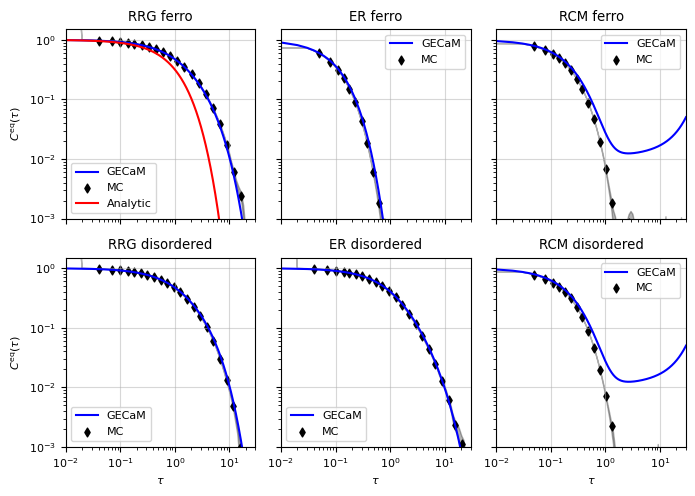

In [28]:
fig, axs = plt.subplots(2, 3, figsize=(7, 5), tight_layout=true, sharex=true, sharey=true)

# RRG Ferro
ax = axs[1, 1]
# Parameters
N, K = 200, 3
lam, J, D = 1.2, 1.0/K, 1.0
tmax = 300.0
nsim = 500
teq = 200.0
# Load data
jldfile = "data/RRG_Ferro/N-$(N)_K-$(K)_lam-$(lam)_D-$(D)_J-$(Int(J*K))_tmax-$(tmax)_nsim-$(nsim)_teq-$(teq).jld2"
tvec_mc, autocorr_traj, err_autocorr_traj, lagvec_mc, lagidxs_mc, tvec_G, C, Ceq_analytic = load(jldfile, "tvec_mc", "autocorr_traj", "err_autocorr_traj", "lagvec_mc", "lagidxs_mc", "tvec_G", "C", "Ceq_analytic")
# Plot correlations
ax.plot(tvec_G, C, color="blue", label="GECaM")
ax.scatter(lagvec_mc[1:3:end], autocorr_traj[1:3:end], color="black", marker="d", s=20, label="MC")
ax.fill_between(lagvec_mc, autocorr_traj .- err_autocorr_traj, autocorr_traj .+ err_autocorr_traj, color="black", alpha=0.3)
ax.plot(tvec_G, Ceq_analytic ./ Ceq_analytic[1], color="red", label="Analytic")
ax.legend()
ax.set_ylabel(L"C^{\rm eq}(\tau)")
ax.set_title("RRG ferro")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(1e-3, 1.5)
ax.set_xlim(1e-2, 3e1)
ax.grid(alpha=.5)

# ER ferro
ax = axs[1, 2]
# Parameters
N, K = 200, 4
lam, J, D = 10.0, 1.0/K, 1.0
tmax = 500.0
nsim = 100
teq = 400.0
# Load data
jldfile = "data/ER_Ferro/N-$(N)_K-$(K)_lam-$(lam)_D-$(D)_J-$(Int(J*K))_tmax-$(tmax)_nsim-$(nsim)_teq-$(teq).jld2"
tvec_mc, autocorr_traj, err_autocorr_traj, lagvec_mc, lagidxs_mc, tvec_G, C = load(jldfile, "tvec_mc", "autocorr_traj", "err_autocorr_traj", "lagvec_mc", "lagidxs_mc", "tvec_G", "C")
# Plot correlations
ax.plot(tvec_G, C, color="blue", label="GECaM")
ax.scatter(lagvec_mc[1:3:end], autocorr_traj[1:3:end], color="black", marker="d", s=20, label="MC")
ax.fill_between(lagvec_mc, autocorr_traj .- err_autocorr_traj, autocorr_traj .+ err_autocorr_traj, color="black", alpha=0.3)
ax.legend()
ax.set_title("ER ferro")
ax.set_yscale("log")
ax.set_xscale("log")
ax.grid(alpha=.5)

# RCM ferro
ax = axs[1, 3]
# Parameters
N, K = 200, 2.89
lam, J, D = 5.0, 1.0/K, 1.0
tmax = 500.0
nsim = 100
teq = 400.0
# Load data
jldfile = "data/RCM_Ferro/N-$(N)_K-$(K)_lam-$(lam)_D-$(D)_J-$(Int(J*K))_tmax-$(tmax)_nsim-$(nsim)_teq-$(teq).jld2"
tvec_mc, autocorr_traj, err_autocorr_traj, lagvec_mc, lagidxs_mc, tvec_G, C = load(jldfile, "tvec_mc", "autocorr_traj", "err_autocorr_traj", "lagvec_mc", "lagidxs_mc", "tvec_G", "C")
# Plot correlations
ax.plot(tvec_G, C, color="blue", label="GECaM")
ax.scatter(lagvec_mc[1:3:end], autocorr_traj[1:3:end], color="black", marker="d", s=20, label="MC")
ax.fill_between(lagvec_mc, autocorr_traj .- err_autocorr_traj, autocorr_traj .+ err_autocorr_traj, color="black", alpha=0.3)
ax.legend()
ax.set_title("RCM ferro")
ax.set_yscale("log")
ax.set_xscale("log")
ax.grid(alpha=.5)

# RRG disordered
ax = axs[2, 1]
# Parameters
N, K = 200, 3
lam, J, D = 1.2, 1.0/K, 1.0
tmax = 300.0
nsim = 500
teq = 200.0
# Load data
jldfile = "data/RRG_Dis/N-$(N)_K-$(K)_lam-$(lam)_D-$(D)_J-$(Int(J*K))_tmax-$(tmax)_nsim-$(nsim)_teq-$(teq).jld2"
tvec_mc, autocorr_traj, err_autocorr_traj, lagvec_mc, lagidxs_mc, tvec_G, C = load(jldfile, "tvec_mc", "autocorr_traj", "err_autocorr_traj", "lagvec_mc", "lagidxs_mc", "tvec_G", "C")
# Plot correlations
ax.plot(tvec_G, C, color="blue", label="GECaM")
ax.scatter(lagvec_mc[1:3:end], autocorr_traj[1:3:end], color="black", marker="d", s=20, label="MC")
ax.fill_between(lagvec_mc, autocorr_traj .- err_autocorr_traj, autocorr_traj .+ err_autocorr_traj, color="black", alpha=0.3)
ax.legend()
ax.set_ylabel(L"C^{\rm eq}(\tau)")
ax.set_xlabel(L"\tau")
ax.set_title("RRG disordered")
ax.set_yscale("log")
ax.set_xscale("log")
ax.grid(alpha=.5)

# ER disordered
ax = axs[2, 2]
# Parameters
N, K = 100, 4
lam, J, D = 1.3, 1.0/K, 1.0
tmax = 300.0
nsim = 500
teq = 200.0
# Load data
jldfile = "data/ER_Dis/N-$(N)_K-$(K)_lam-$(lam)_D-$(D)_J-$(Int(J*K))_tmax-$(tmax)_nsim-$(nsim)_teq-$(teq).jld2"
tvec_mc, autocorr_traj, err_autocorr_traj, lagvec_mc, lagidxs_mc, tvec_G, C = load(jldfile, "tvec_mc", "autocorr_traj", "err_autocorr_traj", "lagvec_mc", "lagidxs_mc", "tvec_G", "C")
# Plot correlations
ax.plot(tvec_G, C, color="blue", label="GECaM")
ax.scatter(lagvec_mc[1:3:end], autocorr_traj[1:3:end], color="black", marker="d", s=20, label="MC")
ax.fill_between(lagvec_mc, autocorr_traj .- err_autocorr_traj, autocorr_traj .+ err_autocorr_traj, color="black", alpha=0.3)
ax.legend()
ax.set_title("ER disordered")
ax.set_xlabel(L"\tau")
ax.set_yscale("log")
ax.set_xscale("log")
ax.grid(alpha=.5)

# RCM disordered
ax = axs[2, 3]
# Parameters
N, K = 200, 2.89
lam, J, D = 5.0, 1.0/K, 1.0
tmax = 500.0
nsim = 100
teq = 400.0 
# Load data
jldfile = "data/RCM_Dis_Bim/N-$(N)_K-$(K)_lam-$(lam)_D-$(D)_J-$(Int(J*K))_tmax-$(tmax)_nsim-$(nsim)_teq-$(teq).jld2"
tvec_mc, autocorr_traj, err_autocorr_traj, lagvec_mc, lagidxs_mc, tvec_G, C = load(jldfile, "tvec_mc", "autocorr_traj", "err_autocorr_traj", "lagvec_mc", "lagidxs_mc", "tvec_G", "C")
# Plot correlations
ax.plot(tvec_G, C, color="blue", label="GECaM")
ax.scatter(lagvec_mc[1:3:end], autocorr_traj[1:3:end], color="black", marker="d", s=20, label="MC")
ax.fill_between(lagvec_mc, autocorr_traj .- err_autocorr_traj, autocorr_traj .+ err_autocorr_traj, color="black", alpha=0.3)
ax.legend()
ax.set_title("RCM disordered")
ax.set_xlabel(L"\tau")
ax.set_yscale("log")
ax.set_xscale("log")
ax.grid(alpha=.5)

plt.display(fig)

fig.savefig("Ceq_all.png", dpi=300, bbox_inches="tight")
fig.savefig("Ceq_all.pdf", bbox_inches="tight")

## Random Regular Graph with disordered interactions (gaussian)

In [ ]:
N, K = 200, 3

rng = Xoshiro(1234)

lam, J, D = 2.5, 1.0/K, 1.0
Jmat = adjacency_matrix(random_regular_graph(N, K; rng=rng), Float64)
@inbounds @fastmath for i in 1:N
    @inbounds @fastmath @simd for j in i+1:N
        if Jmat[i, j] != 0
            Jmat[i, j] = randn(rng) * J
            Jmat[j, i] = Jmat[i, j]
        end
    end
end
lambdas = fill(lam, N)

x0_min, x0_max = 1.0, 1.0
gen_J(N, K, J_params; rng=Xoshiro(1234)) = deepcopy(Jmat)
gen_x0(N, x0_params; rng=Xoshiro(1234)) = rand(rng, N) .* (x0_params[2] - x0_params[1]) .+ x0_params[1]
J_params = [J]
x0_params = [x0_min, x0_max]

ensemble_model = OUModelEnsemble(N, K, gen_J, J_params, lambdas, D, gen_x0, x0_params)

dt_mc = 1e-2
tmax = 300.0
tsave_mc = collect(range(0.0, tmax; step=dt_mc))
T_mc = length(tsave_mc)

nsim = 500

# Sample ensemble
tvals_alls, traj_alls = sample_ensemble_OU(ensemble_model, tmax, tsave_mc, nsim; rng=rng, showprogress=true, dt=dt_mc);

In [ ]:
tvec_mc = collect(range(0.0, tmax; length=200))
tidxs_mc = [argmin(abs.(tsave_mc .- t)) for t in tvec_mc]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Plot all trajectories
for isim in rand(rng, 1:nsim, 30)
    for i in rand(rng, 1:N, 50)
        ax.plot(tvec_mc, view(traj_alls[isim],i,tidxs_mc), color="k", alpha=0.01)
    end
end
# Plot mean and std
mean_traj, std_traj = compute_meanstd(traj_alls; time_indices=tidxs_mc)
ax.plot(tvec_mc, mean_traj, color="red")
ax.fill_between(tvec_mc, mean_traj .- std_traj, mean_traj .+ std_traj, color="red", alpha=0.5)
ax.set_ylabel("x")
ax.set_xlabel("t")

plt.display(fig)

In [ ]:
teq = 200.0
teq_idx = argmin(abs.(tsave_mc .- teq))

model = OUModel(K, Jmat, lambdas, D)

dt_G = 1e-2

T_G = Int((tmax-teq)/dt_G)
nodes = run_cavity_EQ(model, dt_G, T_G; showprogress=true)

C, R = compute_averages(nodes, model, T_G);

In [ ]:
lagvec_mc = exp10.(collect(range(log10(1e-2), log10((tmax-teq)); length=100)))
lagidxs_mc = [argmin(abs.(view(tsave_mc,teq_idx:T_mc) .- teq .- t)) for t in lagvec_mc] 
# Remvoe duplicates
lagidxs_mc = unique(lagidxs_mc)
lagvec_mc = tsave_mc[lagidxs_mc]

tvec_G = collect(range(0, T_G*dt_G, length=T_G + 1))

autocorr_traj, err_autocorr_traj, l_idx = compute_autocorr_TTI(traj_alls, teq_idx; lag_indices=lagidxs_mc)
lagvec_mc = tsave_mc[l_idx]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Plot correlations
ax.plot(tvec_G, C, color="blue", label="GECaM")
ax.scatter(lagvec_mc, autocorr_traj, color="black", label="MC")
ax.fill_between(lagvec_mc, autocorr_traj .- err_autocorr_traj, autocorr_traj .+ err_autocorr_traj, color="black", alpha=0.1)
ax.legend()
ax.set_xlabel("τ")
ax.set_ylabel("Ceq(τ)")
ax.set_title("Equilibrium correlation")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(1e-4, 1.5)
ax.set_xlim(1e-2, 5e1)
ax.grid(alpha=.5)

plt.display(fig)   
fig.savefig("Ceq_RRG_Dis_Gauss_N-$(N)_K-$(K)_lam-$(lam)_D-$(D)_J-$(Int(J*K)).png", dpi=300, bbox_inches="tight")

In [ ]:
isdir("data") || mkdir("data")
isdir("data/RRG_Dis_Gauss") || mkdir("data/RRG_Dis_Gauss")

jldsave("data/RRG_Dis_Gauss/N-$(N)_K-$(K)_lam-$(lam)_D-$(D)_J-$(Int(J*K))_tmax-$(tmax)_nsim-$(nsim)_teq-$(teq).jld2"; tvals_alls, traj_alls, tvec_mc, mean_traj, std_traj, autocorr_traj, err_autocorr_traj, lagvec_mc, lagidxs_mc, tvec_G, C)

## Erdos-Renyi with disordered interactions (gaussian)

In [ ]:
N, K = 100, 4

rng = Xoshiro(1234)

lam, J, D = 2.5, 1.0/K, 1.0
Jmat = adjacency_matrix(erdos_renyi(N, K/N; rng=rng), Float64) 
@inbounds @fastmath for i in 1:N
    @inbounds @fastmath @simd for j in i+1:N
        if Jmat[i, j] != 0
            Jmat[i, j] = randn(rng) * J
            Jmat[j, i] = Jmat[i, j]
        end
    end
end
lambdas = fill(lam, N)

x0_min, x0_max = 1.0, 1.0
gen_J(N, K, J_params; rng=Xoshiro(1234)) = deepcopy(Jmat)
gen_x0(N, x0_params; rng=Xoshiro(1234)) = rand(rng, N) .* (x0_params[2] - x0_params[1]) .+ x0_params[1]
J_params = [J]
x0_params = [x0_min, x0_max]

ensemble_model = OUModelEnsemble(N, K, gen_J, J_params, lambdas, D, gen_x0, x0_params)

dt_mc = 1e-2
tmax = 300.0
tsave_mc = collect(range(0.0, tmax; step=dt_mc))
T_mc = length(tsave_mc)

nsim = 500

# Sample ensemble
tvals_alls, traj_alls = sample_ensemble_OU(ensemble_model, tmax, tsave_mc, nsim; rng=rng, showprogress=true, dt=dt_mc);

In [ ]:
tvec_mc = collect(range(0.0, tmax; length=200))
tidxs_mc = [argmin(abs.(tsave_mc .- t)) for t in tvec_mc]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Plot all trajectories
for isim in rand(rng, 1:nsim, 30)
    for i in rand(rng, 1:N, 50)
        ax.plot(tvec_mc, view(traj_alls[isim],i,tidxs_mc), color="k", alpha=0.01)
    end
end
# Plot mean and std
mean_traj, std_traj = compute_meanstd(traj_alls; time_indices=tidxs_mc)
ax.plot(tvec_mc, mean_traj, color="red")
ax.fill_between(tvec_mc, mean_traj .- std_traj, mean_traj .+ std_traj, color="red", alpha=0.5)
ax.set_ylabel("x")
ax.set_xlabel("t")

plt.display(fig)

In [ ]:
teq = 200.0
teq_idx = argmin(abs.(tsave_mc .- teq))

model = OUModel(K, Jmat, lambdas, D)

dt_G = 1e-2

T_G = Int((tmax-teq)/dt_G)
nodes = run_cavity_EQ(model, dt_G, T_G; showprogress=true)

C, R = compute_averages(nodes, model, T_G);

In [ ]:
lagvec_mc = exp10.(collect(range(log10(1e-2), log10((tmax-teq)); length=100)))
lagidxs_mc = [argmin(abs.(view(tsave_mc,teq_idx:T_mc) .- teq .- t)) for t in lagvec_mc] 
# Remvoe duplicates
lagidxs_mc = unique(lagidxs_mc)
lagvec_mc = tsave_mc[lagidxs_mc]

tvec_G = collect(range(0, T_G*dt_G, length=T_G + 1))

autocorr_traj, err_autocorr_traj, l_idx = compute_autocorr_TTI(traj_alls, teq_idx; lag_indices=lagidxs_mc)
lagvec_mc = tsave_mc[l_idx]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Plot correlations
ax.plot(tvec_G, C, color="blue", label="GECaM")
ax.scatter(lagvec_mc, autocorr_traj, color="black", label="MC")
ax.fill_between(lagvec_mc, autocorr_traj .- err_autocorr_traj, autocorr_traj .+ err_autocorr_traj, color="black", alpha=0.1)
ax.legend()
ax.set_xlabel("τ")
ax.set_ylabel("Ceq(τ)")
ax.set_title("Equilibrium correlation")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(1e-4, 1.5)
ax.set_xlim(1e-2, 1e1)
ax.grid(alpha=.5)

plt.display(fig)   
fig.savefig("Ceq_ER_Dis_Gauss_N-$(N)_K-$(K)_lam-$(lam)_D-$(D)_J-$(Int(J*K)).png", dpi=300, bbox_inches="tight")

In [ ]:
isdir("data") || mkdir("data")
isdir("data/ER_Dis_Gauss") || mkdir("data/ER_Dis_Gauss")

jldsave("data/ER_Dis_Gauss/N-$(N)_K-$(K)_lam-$(lam)_D-$(D)_J-$(Int(J*K))_tmax-$(tmax)_nsim-$(nsim)_teq-$(teq).jld2"; tvals_alls, traj_alls, tvec_mc, mean_traj, std_traj, autocorr_traj, err_autocorr_traj, lagvec_mc, lagidxs_mc, tvec_G, C)